# Mount Google Drive

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Read Data

In [2]:
#Read in the raw data from AT&T faces dataset
#files are already located in drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import os
from PIL import Image
import warnings
import glob
import matplotlib.image as mpimg
import cv2

"""
def prepare_images_att(tr_percentage):
    path = '/content/gdrive/Shareddrives/EC503 Project Team/Code/ORL-DATABASE'
    X = []
    y = []
    for i in range(40):
        for j in range(10):
            img = Image.open(os.path.join(path +'/s'+str(i+1), str(j+1)+'.pgm'))
            X.append(np.asarray(img, dtype=np.uint8).flatten())
            y.append(i)
    X = np.asarray(X) #All images
    y = np.asarray(y) #numbered people (40 in total)



    #Create the training and testing datasets
    width = 92
    height = 112
    train_num = int(tr_percentage*len(X))

    np_training_input = X[0:train_num]
    np_training_class = y[0:train_num]

    np_test_input = X[train_num:len(X)]
    np_test_class = y[train_num:len(y)]

    #reshape into correct image sizes
    np_training_input = np_training_input.reshape(-1,height,width)
    np_test_input = np_test_input.reshape(-1,height,width)



    return np_training_input,np_test_input,np_training_class,np_test_class,height,width
"""

def prepare_images_att(num_people,num_pic_tr,num_pic_te):
    path = '/content/gdrive/Shareddrives/EC503 Project Team/Code/ORL-DATABASE'
    X = []
    y = []
    for i in range(40):
        for j in range(10):
            img = Image.open(os.path.join(path +'/s'+str(i+1), str(j+1)+'.pgm'))
            X.append(np.asarray(img, dtype=np.uint8).flatten())
            y.append(i)
    X = np.asarray(X) #All images
    y = np.asarray(y) #numbered people (40 in total)



    #Create the training and testing datasets
    width = 92
    height = 112
    
    
    X=X.reshape(400,height,width)

    
    
    
    
    
    ind=np.arange(num_people)
    train_ind=ind*10
    tmp=ind*10
    
    for i in range(num_pic_tr-1):
        train_ind=np.concatenate([train_ind,tmp+1+i])
        
    train_ind=np.sort(train_ind)
    
    np_training_input=X[train_ind,]    
    np_training_class=y[train_ind,]
    
    
    ind=np.arange(num_people)
    test_ind=ind*10+num_pic_tr
    tmp=ind*10+num_pic_tr
    for i in range(num_pic_te-1):
        test_ind=np.concatenate([test_ind,tmp+1+i])
        
    test_ind=np.sort(test_ind)
    
    np_test_input=X[test_ind,]    
    np_test_class=y[test_ind,]
    



    return width,height,np_training_input,np_test_input,np_training_class,np_test_class


# Create Patches


In [3]:
#SVR.py

from sklearn.feature_extraction import image
import numpy as np
from numpy.lib.stride_tricks import as_strided


def sliding_window(arr, window_size):
    """ Construct a sliding window view of the array"""
    arr = np.asarray(arr)
    window_size = int(window_size)
    if arr.ndim != 2:
        raise ValueError("need 2-D input")
    if not (window_size > 0):
        raise ValueError("need a positive window size")
    shape = (arr.shape[0] - window_size + 1,
             arr.shape[1] - window_size + 1,
             window_size, window_size)
    if shape[0] <= 0:
        shape = (1, shape[1], arr.shape[0], shape[3])
    if shape[1] <= 0:
        shape = (shape[0], 1, shape[2], arr.shape[1])
    strides = (arr.shape[1]*arr.itemsize, arr.itemsize,
               arr.shape[1]*arr.itemsize, arr.itemsize)
    return as_strided(arr, shape=shape, strides=strides)

def cell_neighbors(arr, i, j, d):
    """Return d-th neighbors of cell (i, j)"""
    w = sliding_window(arr, 2*d+1)

    ix = np.clip(i - d, 0, w.shape[0]-1)
    jx = np.clip(j - d, 0, w.shape[1]-1)

    i0 = max(0, i - d - ix)
    j0 = max(0, j - d - jx)
    i1 = w.shape[2] - max(0, d - i + ix)
    j1 = w.shape[3] - max(0, d - j + jx)

    return w[ix, jx][i0:i1,j0:j1].ravel()


def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value





def get_patches(np_training_input,np_training_output,desired_dim,window_size=(5,5)):
    
    width=desired_dim[0]
    height=desired_dim[1]
    tmp=int(window_size[0]-1)
    one_tmp=int(tmp/2)

    y=np.zeros(width*height*len(np_training_input))
    x=np.zeros((width*height*len(np_training_input),window_size[0]*window_size[1]))


    for z in range (len(np_training_input)):
        array_tmp=z*width*height
        img=np_training_input[z,]
        img_y=np_training_output[z,]
        #zimg = np.zeros((height+tmp, width+tmp))
        #zimg[one_tmp:height+one_tmp, one_tmp:width+one_tmp] = img
        
        
        padded=np.pad(img, one_tmp, pad_with, padder=-879)
        #print(padded)
        cntrl=np.where(padded!=-879)
        cntrl=(np.asarray(cntrl).T).tolist()
        
        patches = []
        
        for pos in cntrl:
            #print(pos)
            tmp_padded=padded[pos[0]-one_tmp:pos[0]+one_tmp+1,pos[1]-one_tmp:pos[1]+one_tmp+1]
            #print(tmp_padded)
            #tmp_padded=tmp_padded[tmp_padded!=-1]
            #me_zeros.append(int(padded[pos[0],pos[1]]))
            patches.append(tmp_padded.flatten())
            #print(tmp_padded)
            
        
        
        #patches = image.extract_patches_2d(zimg, window_size)
        
        
        y[z*width*height:(z+1)*width*height]=img_y.flatten()
        #y=np.zeros(len(patches))
        #x=np.zeros((len(patches),window_size[0]*window_size[1]))
        for i in range (height):
            for j in range (width):
                #y[array_tmp+i*j+j]=img_y[i,j]
                x[array_tmp+i*width+j]=patches[i*width+j].flatten()
                
    x[x==-879]=0
    return(x,y)


def get_patches_single_image(np_training_input,desired_dim,window_size=(5,5)):
    
    width=desired_dim[0]
    height=desired_dim[1]
    tmp=int(window_size[0]-1)
    one_tmp=int(tmp/2)

    y=np.zeros(width*height)
    x=np.zeros((width*height,window_size[0]*window_size[1]))


    
    
    img=np_training_input
    #zimg = np.zeros((height+tmp, width+tmp))
    #zimg[one_tmp:height+one_tmp, one_tmp:width+one_tmp] = img

    padded=np.pad(img, one_tmp, pad_with, padder=-879)
    #print(padded)
    cntrl=np.where(padded!=-879)
    cntrl=(np.asarray(cntrl).T).tolist()
    
    patches = []
    
    for pos in cntrl:
        #print(pos)
        tmp_padded=padded[pos[0]-one_tmp:pos[0]+one_tmp+1,pos[1]-one_tmp:pos[1]+one_tmp+1]
        #print(tmp_padded)
        #tmp_padded=tmp_padded[tmp_padded!=-1]
        #me_zeros.append(int(padded[pos[0],pos[1]]))
        patches.append(tmp_padded.flatten())
        #print(tmp_padded)
    
    #patches = image.extract_patches_2d(zimg, window_size)
    
    
    
    #y=np.zeros(len(patches))
    #x=np.zeros((len(patches),window_size[0]*window_size[1]))
    for i in range (height):
        for j in range (width):
            #y[i*j+j]=img[i,j]
            x[i*width+j]=patches[i*width+j].flatten()
                
    y=img.flatten()
    return(x,y)

# Resize images and (optionally) add blur



In [4]:

import cv2
import numpy as np

def add_blur_decrease_size(np_training_input,desired_dim,add_blur=False):
    
    
    no_of_training=len(np_training_input)
    
    
    training_input=[None]*no_of_training
    
    
    for i in range(no_of_training):
        tr=np_training_input[i,]
        if add_blur==True:
            tr = cv2.GaussianBlur(tr, (3,3),0)
        resized = cv2.resize(tr, desired_dim)
        training_input[i]=resized
        
    
    width=desired_dim[0]
    height=desired_dim[1]
    training_input=np.array(training_input)
    
    
    return width,height,training_input

# Generate Training and Testing Data


In [5]:
num_people=20
num_tr=3
num_te=1
width,height,np_training_input,np_test_input,np_training_class,np_test_class = prepare_images_att(num_people,num_tr,num_te)

no_of_tr_pictures=len(np_training_input)
no_of_test_pictures=len(np_test_input)

tr_input_row=np_training_input.reshape(no_of_tr_pictures,height*width)
test_input_row=np_test_input.reshape(no_of_test_pictures,height*width)

# Downsize then upsize images to create blur effect

In [6]:
#We will downsize HR images of original size to 64x64 first. the first 64x64 will act as the "HR" images
downsize_dim = (64,64)
width,height,hr_train = add_blur_decrease_size(np_training_input,downsize_dim,add_blur=False)
width,height,hr_test = add_blur_decrease_size(np_test_input,downsize_dim,add_blur=False)

downsize_dim = (32,32)
width,height,lr_train = add_blur_decrease_size(hr_train,downsize_dim,add_blur=False)
width,height,lr_test = add_blur_decrease_size(hr_test,downsize_dim,add_blur=False)

upsize_dim = (64,64)
width,height,lr_train = add_blur_decrease_size(lr_train,upsize_dim,add_blur=False)
width,height,lr_test = add_blur_decrease_size(lr_test,upsize_dim,add_blur=False)


# Generate Patches

In [7]:
#Sliding window size
w_size = (5,5)

#Define training X and y patches
xtrain,ytrain = get_patches(lr_train.astype(float),hr_train,upsize_dim,w_size)

#Create testing patches
xtest,ytest=get_patches(lr_test.astype(float),hr_test,upsize_dim,w_size)


# Train SVR model and make prediction

In [8]:
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import random
import time


#choose percentage of the patches to train on
how_many_pics_to_train = int(.1*len(xtrain))       #30% of patches
ind = random.sample(range(0,len(xtrain)),how_many_pics_to_train)   

xtrain_sampled = xtrain[ind]
ytrain_sampled = ytrain[ind]

#Make_pipeline and standard scaler normalize data
regr = make_pipeline(StandardScaler(), SVR(C=350, epsilon=2))
start = time.time()
svr = regr.fit(xtrain_sampled, ytrain_sampled)
end = time.time()
print(f"Training time for {len(xtrain_sampled)} patches is {end - start} seconds")

#this will make a prediction for all of the test images
#start = time.time()
prediction=svr.predict(xtest)
end2 = time.time()
print(f"Time to make prediction on {len(xtest)} patches is {end2 - end} seconds")

#Extract all prediction images into correct sizes
prediction_pics = prediction.reshape(-1,height,width)



Training time for 24576 patches is 60.63592720031738 seconds
Time to make prediction on 81920 patches is 109.81212854385376 seconds


#Use Cross-Validation to determine optimized C and epsilon values for SVR (One time only)

In [ ]:
"""from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
regressor = SVR()
param_grid = {
                 'C': [1, 100, 350, 1000, 100000],
                 'epsilon': [0.01, 0.1, 1, 2, 10]
             }
# GridSearchCV automatically gives back the best parameters

grid_regressor = GridSearchCV(regressor, param_grid, cv=2, n_jobs=-1, verbose=4)
grid_regressor.fit(xtrain_sampled, ytrain_sampled)
  
print(grid_regressor.best_params_)

#Best parameters of the above options:
#{'C': 350, 'epsilon': 2}"""

Fitting 2 folds for each of 25 candidates, totalling 50 fits
{'C': 350, 'epsilon': 2}


# Export to CSV in Drive

In [ ]:
#Write to csv
"""import csv
prediction_by_row = prediction.reshape(no_of_test_pictures,-1)
pd.DataFrame(prediction_by_row).to_csv("/content/gdrive/Shareddrives/EC503 Project Team/Code/predictions.csv",header=None,index=None)"""

# Calculate MSE and PSNR differences between interpolated images and SVR reconstructed images



In [9]:
import skimage
from skimage import metrics
from tabulate import tabulate


def mse_psnr_ssim(all_hr_test,all_lr_test,all_predictions):
    interp_psnr=[]
    interp_mse=[]
    svr_psnr=[]
    svr_mse=[]
    interp_ssim=[]
    svr_ssim=[]
    #Calculate different metrics between HR-LR, and between HR-reconstructed
    #Calculates PSNR, MSE, and SSIM for all test and prediction examples
    for i in range(no_of_test_pictures):
        #Peak Signal to Noise Ratio
        interp_psnr.append( cv2.PSNR(all_hr_test[i].astype(float),all_lr_test[i].astype(float)))
        svr_psnr.append( cv2.PSNR(all_hr_test[i].astype(float),all_predictions[i]))
        #Mean-Squared Error
        interp_mse.append(skimage.metrics.mean_squared_error(all_hr_test[i].astype(float),all_lr_test[i].astype(float)))
        svr_mse.append( skimage.metrics.mean_squared_error(all_hr_test[i].astype(float),all_predictions[i]))
        #Structural Similarity Index Measure
        interp_ssim.append(skimage.metrics.structural_similarity(all_hr_test[i].astype(float),all_lr_test[i].astype(float)))
        svr_ssim.append(skimage.metrics.structural_similarity(all_hr_test[i].astype(float),all_predictions[i].astype(float)))

    #take mean of each metric over all test images
    print("Average test psnr between HR and interpolated: ", str(np.mean(np.array(interp_psnr))))
    print("Average test psnr between HR and SVR predicted: ", str(np.mean(np.array(svr_psnr))))
    print("Average test mse between HR and interpolated: ", str(np.mean(np.array(interp_mse))))
    print("Average test mse between HR and SVR predicted: ", str(np.mean(np.array(svr_mse))))
    print("Average test SSIM between HR and interpolated: ", str(np.mean(np.array(interp_ssim))))
    print("Average test SSIM between HR and SVR predicted: ", str(np.mean(np.array(svr_ssim))))
    



    return 
mse_psnr_ssim(hr_test,lr_test,prediction_pics)

Average test psnr between HR and interpolated:  28.439838571801253
Average test psnr between HR and SVR predicted:  30.600758453186984
Average test mse between HR and interpolated:  101.58548583984376
Average test mse between HR and SVR predicted:  62.716212779918465
Average test SSIM between HR and interpolated:  0.8661160118100885
Average test SSIM between HR and SVR predicted:  0.9169151419451577


In [ ]:
interp_psnr = cv2.PSNR(hr_test[2].astype(float),lr_test[2].astype(float))
svr_psnr= cv2.PSNR(hr_test[2].astype(float),prediction_pics[2])

interp_ssim = skimage.metrics.structural_similarity(hr_test[2].astype(float),lr_test[2].astype(float))
svr_ssim = skimage.metrics.structural_similarity(hr_test[2].astype(float),prediction_pics[2].astype(float))

print(f"PSNR between HR and interpolated:{interp_psnr} ")
print(f"PSNR between HR and SVR predicted:{svr_psnr} ")

print(f"SSIM between HR and interpolated:{interp_ssim} ")
print(f"SSIM between HR and SVR predicted:{svr_ssim} ")


PSNR between HR and interpolated:29.94717199215199 
PSNR between HR and SVR predicted:32.70989310505532 
SSIM between HR and interpolated:0.9004381716521832 
SSIM between HR and SVR predicted:0.9503070510189855 


#Visualization of results on plot

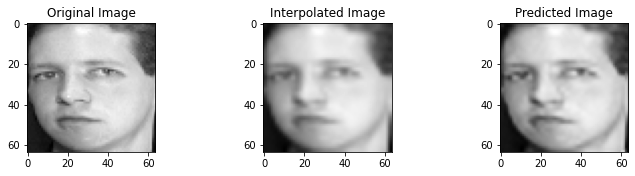

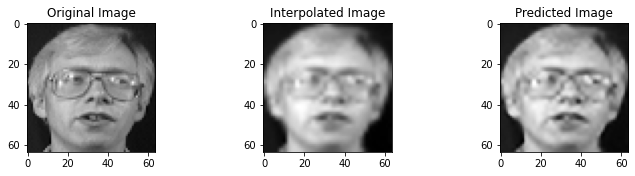

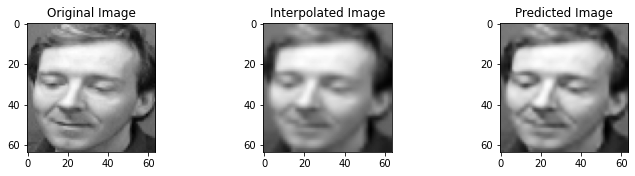

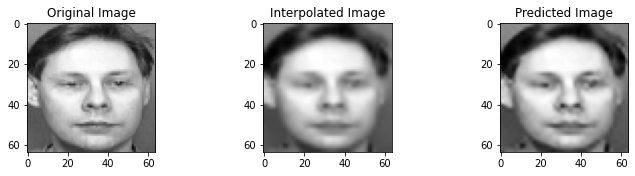

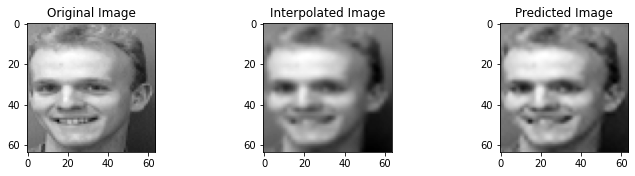

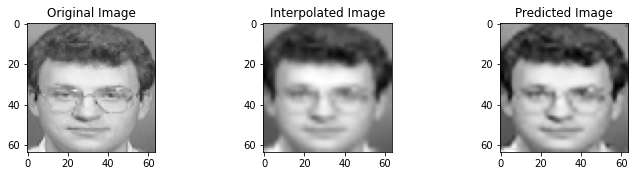

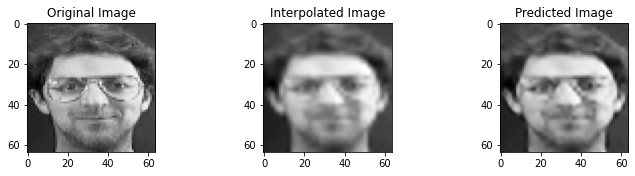

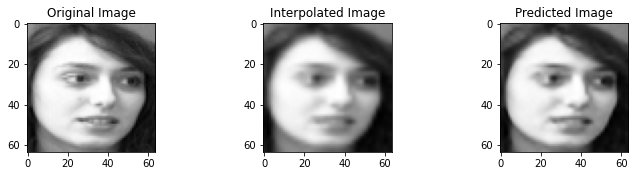

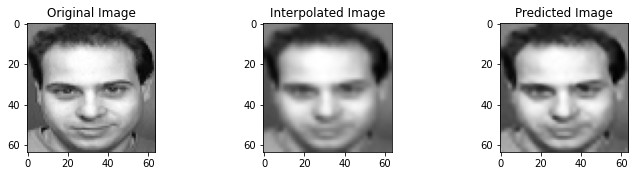

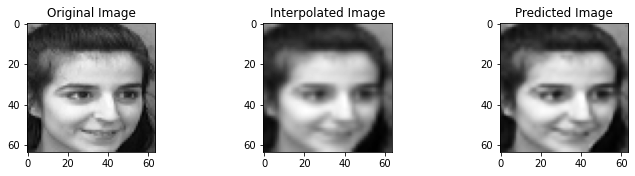

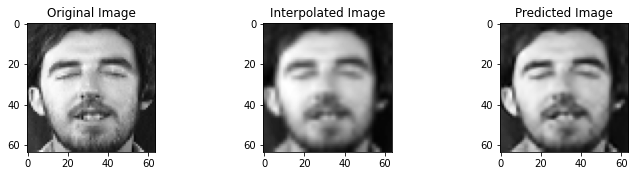

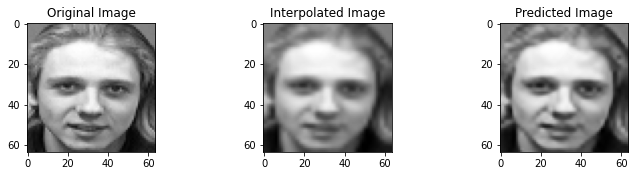

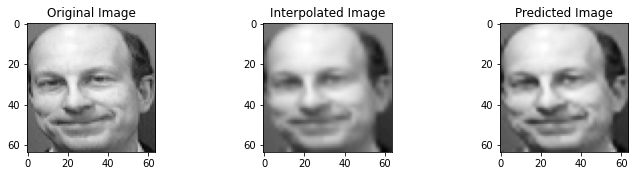

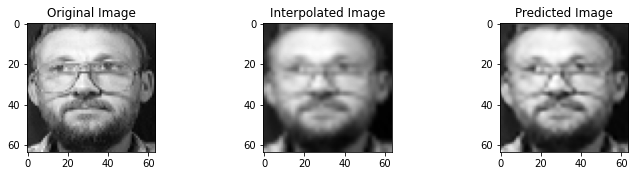

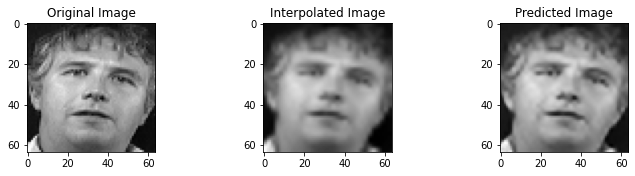

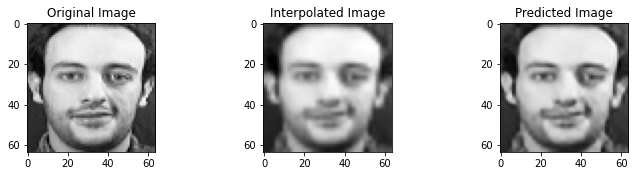

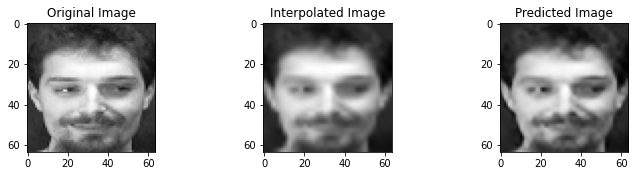

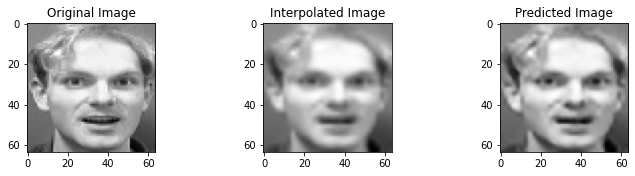

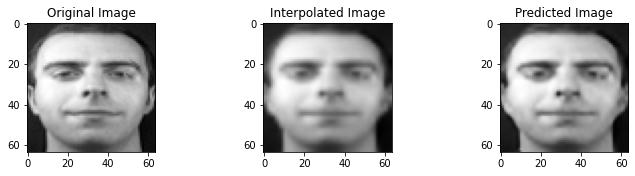

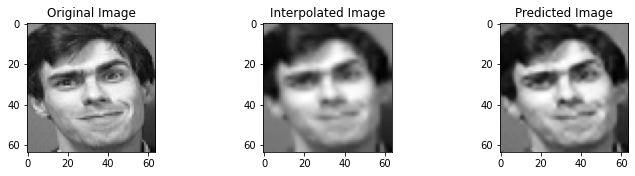

In [10]:
#Create a triplet plot showing an HR image, it's interpolated counterpart, and the predicted HR image reconstructed using SVR
def triplet_plot(hr_image,interp_image,reconstructed_image):
    #Plot high res, low res(interpolated), and super-resolved
    fig1 = plt.figure(1)
    fig1.set_figheight(10)
    fig1.set_figwidth(10)
    ax1 = plt.subplot2grid(shape=(9,9), loc=(0, 0), rowspan=2, colspan=2)
    ax2 = plt.subplot2grid(shape=(9,9), loc=(0, 3), rowspan=2, colspan=2)
    ax3 = plt.subplot2grid(shape=(9,9), loc=(0, 6), rowspan=2, colspan=2)
    # plotting subplots
    ax1.imshow(hr_image, cmap='binary_r',label="dasd")
    ax1.set_title('Original Image')
    ax2.imshow(interp_image, cmap='binary_r',label="dasd")
    ax2.set_title('Interpolated Image')
    ax3.imshow(reconstructed_image, cmap='binary_r',label="dasd")
    ax3.set_title('Predicted Image')
    plt.tight_layout()
    plt.show()

    return

for i in range(no_of_test_pictures):
    triplet_plot(hr_test[i],lr_test[i],prediction_pics[i])